# Adversarial Attack and Detection in Medical Images using Deap Learning

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Partition of data

In [2]:
# Imports
from utils import partition_data

# Partition data into training, validation and test sets
partition_data(file='data/data_labels.csv', ratios=[0.70, 0.20, 0.10], out_path='data/')

PARTITIONED DATA
  Training:   70%, 846 samples
  Testing:    20%, 242 samples
  Validation: 10%, 121 samples


## Import and transform data

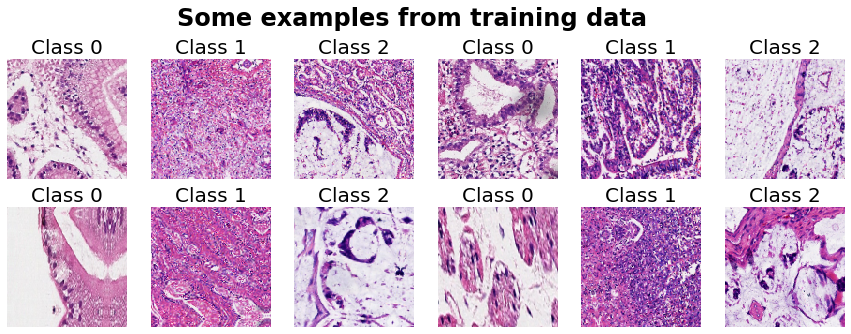

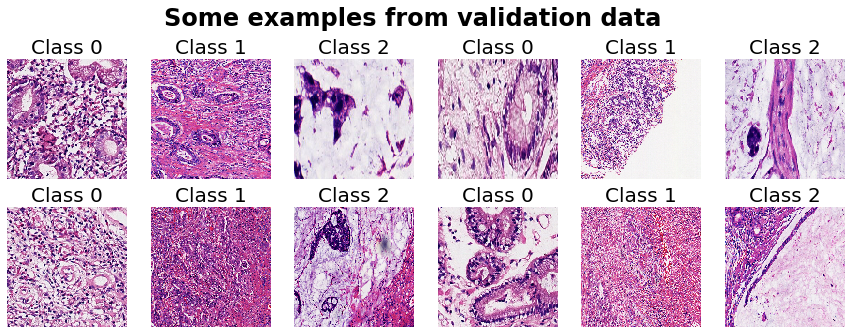

In [3]:
# Imports
import cv2
import albumentations as album
from albumentations.augmentations.transforms import GaussianBlur, MedianBlur, MotionBlur, RandomBrightness, \
                                                    RandomContrast,  VerticalFlip
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torchvision
from data import DatasetFromCSV
from plot import plot_dataset



# Settings
image_size = 128
batch_size = 16
num_workers = 4


# Albumentations
album_train = album.Compose([
    album.Resize(image_size, image_size),
#     album.OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
#     album.OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
    album.VerticalFlip(p=0.5),
    album.HorizontalFlip(p=0.5),
    album.ShiftScaleRotate(
        shift_limit=0.2,
        scale_limit=0.2,
        rotate_limit=20,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        p=1,
    ),
#     album.Normalize(mean=[0.75450546, 0.5585909, 0.7504382], std=[0.18699214, 0.2685904, 0.15489358]),
    album.Normalize(mean=[0,0,0], std=[1,1,1]),
    ToTensorV2(),
])

album_validation = album.Compose([
    album.Resize(image_size, image_size),
#     album.Normalize(mean=[0.7790739, 0.58031166, 0.75693846], std=[0.17999493, 0.27398717, 0.1621663]),
    album.Normalize(mean=[0,0,0], std=[1,1,1]),
    ToTensorV2(),
])


# Load training and validation data sets
dataset_train = DatasetFromCSV("./data/data_images/", "./data/data_labels_train.csv", transforms=album_train)
dataset_validation = DatasetFromCSV("./data/data_images/", "./data/data_labels_validation.csv", transforms=album_validation)

# Plot some examples from training and validation data sets
rows = 2
cols = 6
image_width = 2.5
fig, axs = plot_dataset(dataset_train, rows=rows, cols=cols, image_width=image_width)
fig.suptitle('Some examples from training data', fontsize=24, y=1.02, weight='bold')
fig, axs = plot_dataset(dataset_validation, rows=rows, cols=cols, image_width=image_width)
fig.suptitle('Some examples from validation data', fontsize=24, y=1.02, weight='bold')
plt.show()

# Load data into loaders
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loader_validation = DataLoader(dataset=dataset_validation, batch_size=batch_size, num_workers=num_workers)

## Train classifier

In [4]:
# Imports
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.tensorboard import SummaryWriter
from models.efficientnet import EfficientNet
from core import core_efficientnet
from utils import create_save_path, SaveBestModel


# Settings
session = 1
save_path = './checkpoints/'+str(datetime.date(datetime.now()))+'_'+str(session)
num_classes = 3
initial_lr = 0.05
epochs = 3


# Model
model = EfficientNet.from_name('efficientnet-b0', num_classes=num_classes)

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function
loss_func = torch.nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = torch.optim.Adam(lr=initial_lr, params=model.parameters(), betas=(0.9, 0.99))

# Learning rate decay
optimizer_step = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

# Weight save path
log_path, weight_path = create_save_path(save_path)

# Initialize log writer
log_writer = SummaryWriter(log_path, comment=f'LR_{initial_lr}_BS_{batch_size}')

# Save current model as best model
save_best_model = SaveBestModel(epoch=None, model=model, epochs=epochs, monitor_value=None, weight_path=weight_path,
                                best=None)

# Setup
train_total = len(dataset_train)
valid_total = len(dataset_validation)
time_start = time.time()

for epoch in range(epochs):
    print('Epoch', epoch, end=': ')
    train_acc, train_loss = core_efficientnet.train(model, loader_train, device, loss_func, optimizer, train_total, epoch)
    print(f'train_acc: {train_acc:.4f}, train_loss: {train_loss:.4f}', end=', ')

    valid_acc, valid_loss = core_efficientnet.valid(model, loader_validation, device, loss_func, optimizer, valid_total,
                                                    epoch)
    print(f'valid_acc: {valid_acc:.4f}, valid_loss: {valid_loss:.4f}')

    optimizer_step.step()
    lr = optimizer.param_groups[0]['lr']

    # Save best model only
    save_best_model.epoch = epoch
    save_best_model.monitor_value = valid_acc
    save_best_model.run(model)

    # Write log
    log_writer.add_scalar("Train/Train_Acc", train_acc, epoch)
    log_writer.add_scalar("Train/Val_Acc", valid_acc, epoch)
    log_writer.add_scalar("Train/Train_Loss", train_loss, epoch)
    log_writer.add_scalar("Train/Val_Loss", valid_loss, epoch)
    log_writer.add_scalar("Train/LR", lr, epoch)


time_elapsed = time.time() - time_start
print(f'Total training time: {time_elapsed}S')

Epoch 0: train_acc: 0.3936, train_loss: 3.5929, valid_acc: 0.3760, valid_loss: 2513131464.0000
Saved model.
Epoch 1: train_acc: 0.4882, train_loss: 1.0653, valid_acc: 0.3347, valid_loss: 1922.8661
Epoch 2: train_acc: 0.5745, train_loss: 0.9253, valid_acc: 0.3347, valid_loss: 11.0488
Saved last model.
Total training time: 223.93943190574646S
